In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Datasets_final/q3/train.csv')
df.head()

,SMILES sequence,Binding Affinity
0,CCNC(C)C(NC)c1ccccc1,-18.0861
1,CONC(=O)c1cncnc1,-17.5783
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144
4,CCC(CS)CN(C)c1ccccc1,-15.8451


In [3]:
from rdkit import Chem 

#Method transforms smiles strings to mol rdkit object
df['mol'] = df['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x)) 

#Now let's see what we've got
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


In [6]:
df.head()

,SMILES sequence,Binding Affinity,mol
0,CCNC(C)C(NC)c1ccccc1,-18.0861,<rdkit.Chem.rdchem.Mol object at 0x10c279260>
1,CONC(=O)c1cncnc1,-17.5783,<rdkit.Chem.rdchem.Mol object at 0x10c279170>
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645,<rdkit.Chem.rdchem.Mol object at 0x10c279210>
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144,<rdkit.Chem.rdchem.Mol object at 0x10c2792b0>
4,CCC(CS)CN(C)c1ccccc1,-15.8451,<rdkit.Chem.rdchem.Mol object at 0x10c279300>


In [8]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1


df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [9]:
df.head()

,SMILES sequence,Binding Affinity,mol,num_of_atoms,num_of_heavy_atoms
0,CCNC(C)C(NC)c1ccccc1,-18.0861,<rdkit.Chem.rdchem.Mol object at 0x11fbbd210>,34,14
1,CONC(=O)c1cncnc1,-17.5783,<rdkit.Chem.rdchem.Mol object at 0x11fbd09e0>,18,11
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645,<rdkit.Chem.rdchem.Mol object at 0x11fbd0e90>,35,15
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144,<rdkit.Chem.rdchem.Mol object at 0x11fbd0e40>,34,16
4,CCC(CS)CN(C)c1ccccc1,-15.8451,<rdkit.Chem.rdchem.Mol object at 0x11fbd0f30>,33,14


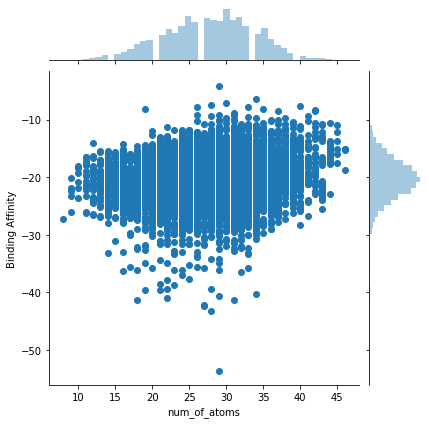

In [10]:
import seaborn as sns
sns.jointplot(df.num_of_atoms, df['Binding Affinity'])
plt.show()

In [11]:
# First we need to settle the pattern.
c_patt = Chem.MolFromSmiles('C')

# Now let's implement GetSubstructMatches() method
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (3,), (4,), (5,), (7,), (8,), (9,), (10,), (11,), (12,), (13,))


In [12]:
#We're going to settle the function that searches patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

In [13]:
df.head()

,SMILES sequence,Binding Affinity,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,CCNC(C)C(NC)c1ccccc1,-18.0861,<rdkit.Chem.rdchem.Mol object at 0x11fbbd210>,34,14,12,0,2,0
1,CONC(=O)c1cncnc1,-17.5783,<rdkit.Chem.rdchem.Mol object at 0x11fbd09e0>,18,11,6,2,3,0
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645,<rdkit.Chem.rdchem.Mol object at 0x11fbd0e90>,35,15,12,0,2,0
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144,<rdkit.Chem.rdchem.Mol object at 0x11fbd0e40>,34,16,12,1,2,0
4,CCC(CS)CN(C)c1ccccc1,-15.8451,<rdkit.Chem.rdchem.Mol object at 0x11fbd0f30>,33,14,12,0,1,0


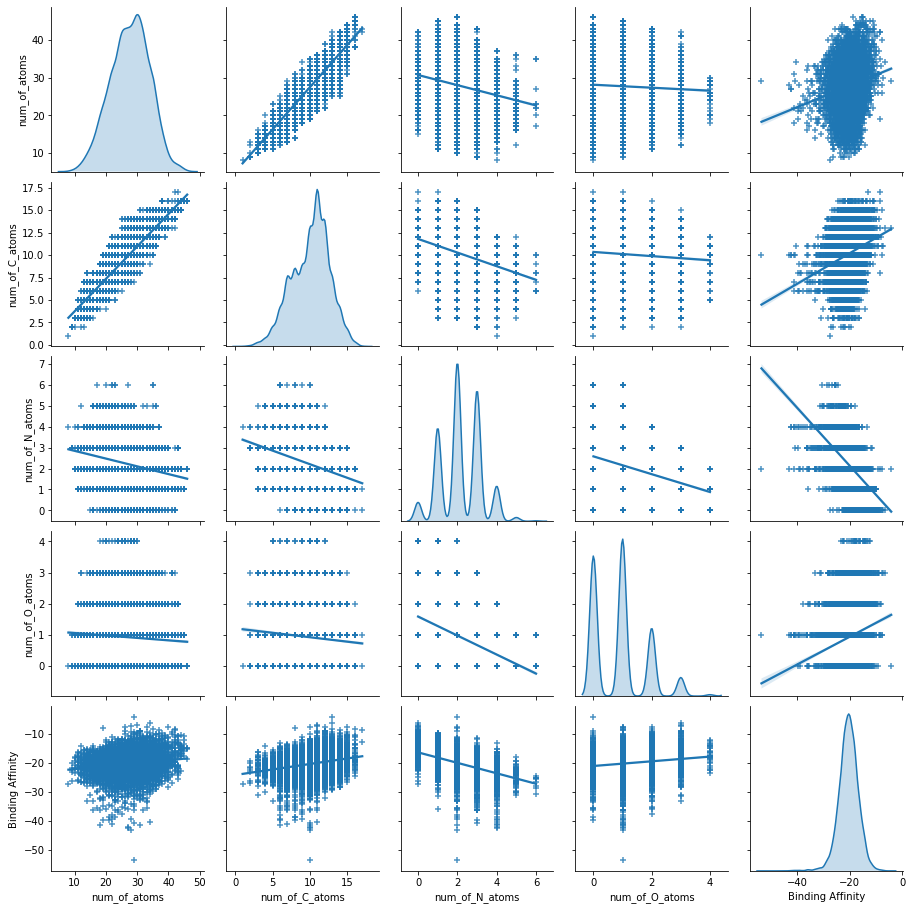

In [14]:
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'Binding Affinity']], diag_kind='kde', kind='reg', markers='+')
plt.show()

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

#Leave only features columns
train_df = df.drop(columns=['SMILES sequence', 'mol', 'Binding Affinity'])
y = df['Binding Affinity'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))

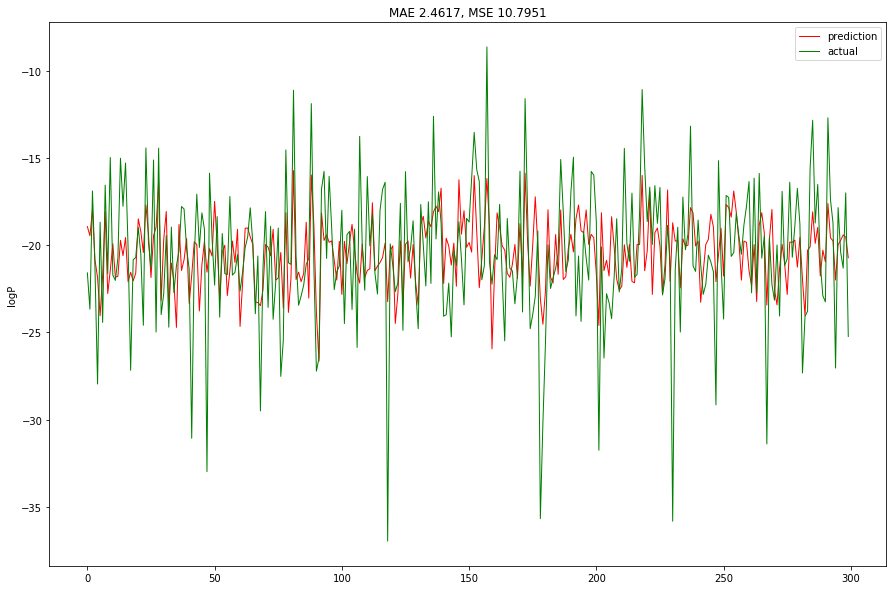

MAE score: 2.4617
MSE score: 10.7951


In [17]:
#Train the model
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
#Evaluate results
evaluation(ridge, X_test, y_test)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))

In [2]:
#Load the dataset and extract target values
mdf= pd.read_csv('./Datasets_final/q3/train.csv', names=['smiles', 
                                           'target'], header=None, skiprows=1)
target = mdf['target']
mdf.drop(columns='target',inplace=True)

In [3]:
#Transforming SMILES to MOL
mdf['mol'] = mdf['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [4]:
mdf.head()

,smiles,mol
0,CCNC(C)C(NC)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x10eb4ff30>
1,CONC(=O)c1cncnc1,<rdkit.Chem.rdchem.Mol object at 0x10eb4ff80>
2,CCNC1CCCN(Cc2ccsc2)C1,<rdkit.Chem.rdchem.Mol object at 0x10f8ab350>
3,CC(NC(=O)CSCCN)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x10f8ab170>
4,CCC(CS)CN(C)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x10f8ab580>


In [5]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./Datasets_final/q3/model_300dim.pkl')

unable to import 'smart_open.gcs', disabling that module


In [6]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)), model, unseen='UNK')))

Molecular sentence: ['2246728737', '3975275337', '864674487', '903112553', '847961216', '2204949651', '2246699815', '1054767590', '864942730', '1510328189', '3217380708', '2994748777', '3218693969', '3777168895', '2041434490', '3118255683', '3218693969', '725322217', '2041434490', '3118255683', '3218693969', '3777168895']

MolSentence object: MolSentence with 22 words

DfVec object: (22, 300) dimensional vector


In [7]:
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

X.shape

(9000, 300)

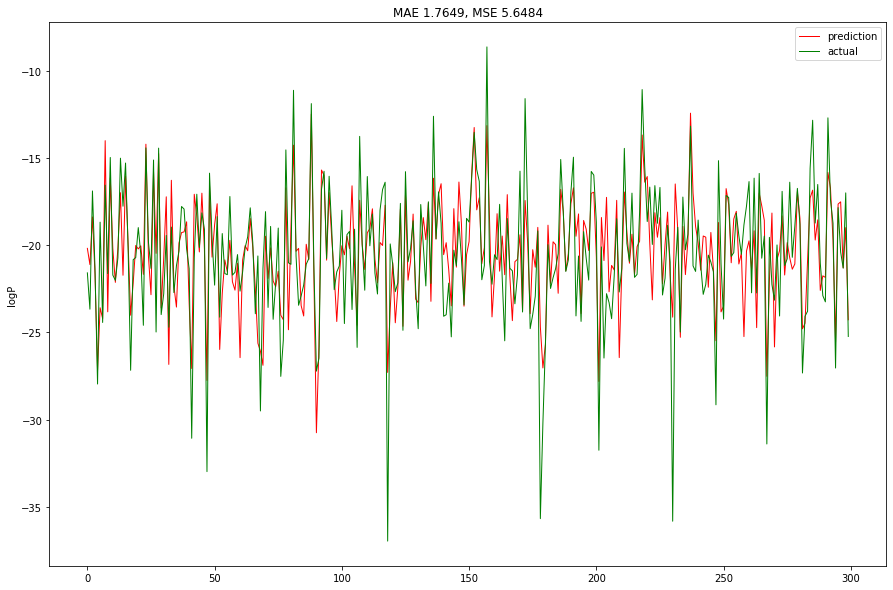

MAE score: 1.7649
MSE score: 5.6484


In [11]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

In [12]:
#Load the dataset and extract target values
df_test= pd.read_csv('./Datasets_final/q3/test.csv', names=['smiles', 
                                           'target'], header=None, skiprows=1)
df_test.drop(columns='target',inplace=True)

In [13]:
#Transforming SMILES to MOL
df_test['mol'] = df_test['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [14]:
df_test.head()

,smiles,mol
0,CNC(=O)N(C)c1ncccn1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
1,O=C(Cc1ccccc1)c1ccccn1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
2,NC1C2CCSCC12,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
3,CCC(C)C(N)(CC)c1ccccc1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
4,N#Cc1cccc(C2OCCC2=O)n1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."


In [15]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./Datasets_final/q3/model_300dim.pkl')

In [16]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(df_test['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(df_test['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(df_test['mol'][1], radius=1)), model, unseen='UNK')))

Molecular sentence: ['864942730', '1510328189', '2246699815', '1909986973', '2245384272', '616374597', '3217380708', '4121755354', '3218693969', '951226070', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '951226070', '3217380708', '3772302167', '3218693969', '951226070', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '3776905034', '2041434490', '1100037548']

MolSentence object: MolSentence with 30 words

DfVec object: (30, 300) dimensional vector


In [17]:
#Constructing sentences
df_test['sentence'] = df_test.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df_test['mol2vec'] = [DfVec(x) for x in sentences2vec(df_test['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in df_test['mol2vec']])
# y = target.values

X.shape

(2500, 300)

In [18]:
df_test.head()

,smiles,mol,sentence,mol2vec
0,CNC(=O)N(C)c1ncccn1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","(2246728737, 3824063894, 847961216, 828793177,...","(300,) dimensional vector"
1,O=C(Cc1ccccc1)c1ccccn1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","(864942730, 1510328189, 2246699815, 1909986973...","(300,) dimensional vector"
2,NC1C2CCSCC12,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","(847957139, 1323888424, 2976033787, 2567653909...","(300,) dimensional vector"
3,CCC(C)C(N)(CC)c1ccccc1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","(2246728737, 3542456614, 2245384272, 150656359...","(300,) dimensional vector"
4,N#Cc1cccc(C2OCCC2=O)n1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","(847433064, 2551483158, 2245900962, 551287920,...","(300,) dimensional vector"


In [19]:
y_pred = ridge.predict(X)

In [20]:
y_pred.shape

(2500,)

In [21]:
sm = df_test['smiles'].values

In [22]:
tt = np.column_stack((sm,y_pred))

In [23]:
tt[0]

array(['CNC(=O)N(C)c1ncccn1', -21.70808219909668], dtype=object)

In [24]:
pd.DataFrame(tt, columns=['SMILES sequence', 'Binding Affinity']).to_csv("./Datasets_final/q3/final_submission.csv", index=False)